In [1]:
import pandas as pd
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.chdir('/Volumes/GoogleDrive/My Drive/BEAM-CORE/BEAM Validation')

plt.style.use('ggplot')

In [3]:
# load parameter and data for validation
meter_to_mile = 0.000621371
percent_of_samples = 0.1
mps_to_mph = 2.23694
scenario_name = 'SF2021V4'
modeled_vmt = read_csv('sample output/SFB2021V4/0.linkstats.csv.gz', low_memory=False)
observed_vmt = read_csv('data for validation/SF/VMT/sf_hpms_inventory_clipped.csv', low_memory=False)
model_network = read_csv('sample output/SFB2021V4/beam_network_by_county.csv', low_memory=False)

modeled_vmt_by_hour = modeled_vmt.groupby('hour')[['volume']].sum()
modeled_vmt.head(5)
print(modeled_vmt_by_hour)

         volume
hour           
0.0       271.0
1.0       436.0
2.0       537.0
3.0       560.0
4.0      2602.0
5.0    809131.0
6.0   1965082.0
7.0   3712518.0
8.0   4661201.0
9.0   3624531.0
10.0  3424879.0
11.0  3507421.0
12.0  3614050.0
13.0  3944381.0
14.0  3750107.0
15.0  3800387.0
16.0  4209996.0
17.0  5218836.0
18.0  5789029.0
19.0  4456676.0
20.0  3239344.0
21.0  2695028.0
22.0  1472491.0
23.0   896281.0
24.0   328887.0
25.0    80749.0
26.0    39864.0
27.0    24209.0
28.0    21854.0
29.0    12802.0
30.0     9737.0
31.0     9546.0
32.0     5532.0
33.0     5287.0
34.0     3415.0
35.0     3030.0
36.0     3531.0
37.0     2409.0
38.0     1588.0
39.0     1601.0
40.0     1810.0
41.0     1088.0
42.0      228.0
43.0      782.0
44.0      653.0
45.0      529.0
46.0      553.0
47.0      732.0
48.0      400.0
49.0      288.0
50.0      205.0
51.0      560.0
52.0      950.0
53.0      269.0
54.0      227.0
55.0       27.0
56.0       10.0
57.0       41.0
58.0        0.0
59.0        0.0


In [4]:
print(observed_vmt.columns)
observed_vmt.loc[:, 'LN_MILES'] = meter_to_mile * observed_vmt.loc[:, 'Through_La'] * observed_vmt.loc[:, 'length (m)']
total_lane_mile_observed = observed_vmt['LN_MILES'].sum()
print(total_lane_mile_observed)
observed_vmt.head(5)

Index(['County_Cod', 'Route_ID', 'Begin_Poin', 'End_Point', 'Route_Numb',
       'F_System', 'Urban_Code', 'Through_La', 'Speed_Limi', 'AADT',
       'AADT_Singl', 'AADT_Combi', 'Shape_Leng', 'STATEFP', 'COUNTYNS',
       'GEOID', 'NAME', 'NAMELSAD', 'LSAD', 'CLASSFP', 'MTFCC', 'CSAFP',
       'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT',
       'INTPTLON', 'length (m)', 'straightdis', 'sinuosity'],
      dtype='object')
21582.60869534815


,County_Cod,Route_ID,Begin_Poin,End_Point,Route_Numb,F_System,Urban_Code,Through_La,Speed_Limi,AADT,...,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,length (m),straightdis,sinuosity,LN_MILES
0,1,ALA_OAK_HEGENBERGER RD_P,0.266,0.300,0,3,78904,2,0,50612,...,36084.0,A,1914242789,212979931,37.647138,-121.912488,57.200693,57.199469,1.000032,0.071086
1,1,SHS_013_P,4.000,4.008,13,2,78904,4,0,64000,...,36084.0,A,1914242789,212979931,37.647138,-121.912488,12.511048,12.511048,1.000000,0.031096
2,1,ALA_UNC_ALMADEN BLVD_P,0.928,0.976,0,5,78904,2,0,4361,...,36084.0,A,1914242789,212979931,37.647138,-121.912488,77.914498,77.914256,1.000005,0.096828
3,1,ALA_OAK_FOOTHILL BLVD_P,1.485,1.530,0,4,78904,2,0,3730,...,36084.0,A,1914242789,212979931,37.647138,-121.912488,73.199445,73.199445,1.000000,0.090968
4,1,ALA_CO_VIA ALAMITOS_P,0.845,1.072,0,5,78904,2,0,26785,...,36084.0,A,1914242789,212979931,37.647138,-121.912488,365.204626,365.204595,1.000000,0.453855


In [5]:
model_network = model_network.drop_duplicates(subset=['linkId'])
model_network.head(5)
model_network.loc[:, 'lane_mile'] = meter_to_mile * model_network.loc[:, 'linkLength'] * model_network.loc[:, 'numberOfLanes']
total_lane_mile_modeled = model_network['lane_mile'].sum()
print(total_lane_mile_modeled)

31459.70759231435


In [6]:
# filter modeled network
model_vmt_24_hour = modeled_vmt.loc[(modeled_vmt['hour'] <= 28) & (modeled_vmt['hour'] >= 5)]
model_vmt_24_hour.loc[model_vmt_24_hour['hour']>=24, 'hour'] -= 24
model_network.loc[:, 'fromNodeId'] = model_network.loc[:, 'fromNodeId'].astype(int)
model_network.loc[:, 'toNodeId'] = model_network.loc[:, 'toNodeId'].astype(int)
model_vmt_24_hour = pd.merge(model_vmt_24_hour, model_network, 
                                 left_on = ['link', 'from', 'to'],
                                 right_on = ['linkId', 'fromNodeId', 'toNodeId'], how = 'left')
model_vmt_24_hour.head(5)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,link,from,to,hour,length,freespeed,capacity,stat,volume,traveltime,...,linkModes,attributeOrigId,attributeOrigType,fromNodeId,toNodeId,GEOID,NAME,NAMELSAD,CLASSFP,lane_mile
0,3640,2519,2518,5.0,49.225,20.11675,2200.0,AVG,1.0,2.446966,...,car;walk;bike,2880.0,trunk,2519.0,2518.0,6085.0,Santa Clara,Santa Clara County,H1,0.030587
1,3640,2519,2518,6.0,49.225,20.11675,2200.0,AVG,3.0,2.449230,...,car;walk;bike,2880.0,trunk,2519.0,2518.0,6085.0,Santa Clara,Santa Clara County,H1,0.030587
2,3640,2519,2518,7.0,49.225,20.11675,2200.0,AVG,5.0,2.446966,...,car;walk;bike,2880.0,trunk,2519.0,2518.0,6085.0,Santa Clara,Santa Clara County,H1,0.030587
3,3640,2519,2518,8.0,49.225,20.11675,2200.0,AVG,10.0,2.453864,...,car;walk;bike,2880.0,trunk,2519.0,2518.0,6085.0,Santa Clara,Santa Clara County,H1,0.030587
4,3640,2519,2518,9.0,49.225,20.11675,2200.0,AVG,6.0,2.453022,...,car;walk;bike,2880.0,trunk,2519.0,2518.0,6085.0,Santa Clara,Santa Clara County,H1,0.030587


In [7]:
model_vmt_24_hour.loc[:, 'lane_mile'] = meter_to_mile * model_vmt_24_hour.loc[:, 'numberOfLanes'] * model_vmt_24_hour.loc[:, 'linkLength'] / 24.0
total_lane_mile_with_cars = model_vmt_24_hour.loc[:, 'lane_mile'].sum()
print(total_lane_mile_with_cars)

31459.70759231435


10.0


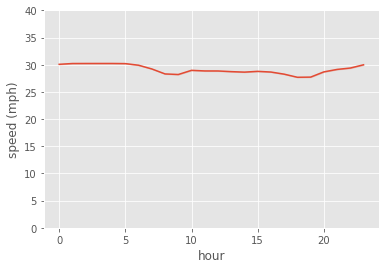

In [8]:

demand_scaling = 1/percent_of_samples
print(demand_scaling)
model_vmt_24_hour.loc[:, 'VMT'] = demand_scaling * meter_to_mile * model_vmt_24_hour.loc[:, 'linkLength'] * model_vmt_24_hour.loc[:, 'volume']
# model_vmt_24_hour.loc[:, 'travel_time (hr)'] = model_vmt_24_hour.loc[:, 'linkLength'] /3600

model_vmt_24_hour.loc[:, 'speed'] = model_vmt_24_hour.loc[:, 'linkLength'] / model_vmt_24_hour.loc[:, 'traveltime'] 
model_vmt_24_hour.loc[:, 'speed (mph)'] = mps_to_mph * model_vmt_24_hour.loc[:, 'speed']
model_vmt_24_hour.loc[:, 'volume'] *= demand_scaling
sns.lineplot(x = 'hour', y = 'speed (mph)', data = model_vmt_24_hour, ci = 95)
plt.ylim([0, 40])
plt.savefig('plot/' + scenario_name + '/modeled_speed_for_all_links.png', dpi = 200)
plt.show()


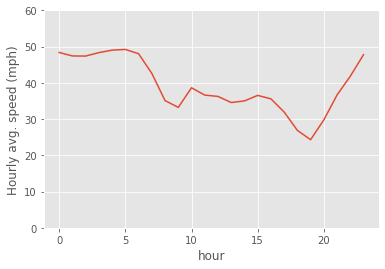

In [9]:
# SUMMARIZE HOURLY SPEED
model_vmt_24_hour.loc[:, 'VMT'] =  meter_to_mile * model_vmt_24_hour.loc[:, 'linkLength'] * model_vmt_24_hour.loc[:, 'volume']
model_vmt_24_hour.loc[:, 'VHT'] =  model_vmt_24_hour.loc[:, 'traveltime'] * model_vmt_24_hour.loc[:, 'volume'] / 3600.0
model_avg_speed = model_vmt_24_hour.groupby('hour')[['VMT','VHT']].sum()
model_avg_speed = model_avg_speed.reset_index()
model_avg_speed.loc[:, 'speed'] = model_avg_speed.loc[:, 'VMT'] / model_avg_speed.loc[:, 'VHT']
model_avg_speed.to_csv('sample output/SFB2021/avg_speed_whole_network.csv', sep = ',', index = False)
sns.lineplot(x = 'hour', y = 'speed', data = model_avg_speed, ci = None)
plt.ylim([0, 60])
plt.ylabel('Hourly avg. speed (mph)')
plt.savefig('plot/' + scenario_name + '/avg_speed_for_all_links.png', dpi = 200)
plt.show()

In [10]:
# create 24 pivot table for speed and volume
speed_by_hour = pd.pivot_table(model_vmt_24_hour, values='speed (mph)', 
                               index=['linkId', 'fromNodeId', 'toNodeId'],
                    columns=['hour'])
speed_by_hour.columns = ['speed_' + str(i+1) for i in range(24)]
speed_by_hour = speed_by_hour.reset_index()
# print(speed_by_hour.head(5))

volume_by_hour = pd.pivot_table(model_vmt_24_hour, values='volume', 
                               index=['linkId', 'fromNodeId', 'toNodeId'],
                    columns=['hour'])
volume_by_hour.columns = ['volume_' + str(i+1) for i in range(24)]
volume_by_hour = volume_by_hour.reset_index()

combined_metric_by_hour = pd.merge(speed_by_hour, volume_by_hour, 
                                   on = ['linkId', 'fromNodeId', 'toNodeId'],
                                    how = 'outer')
combined_metric_by_hour.head(5)
combined_metric_by_hour.to_csv('sample output/SFB2021V4/processed_linkstats.csv', 
                               sep = ',', index = False)

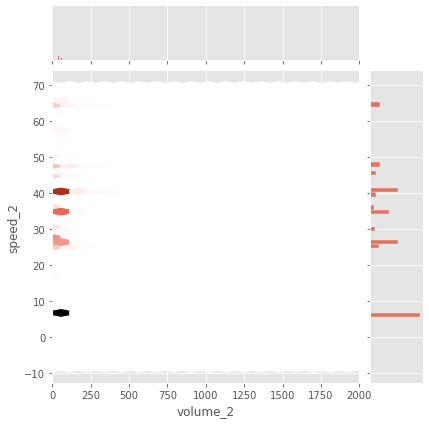

In [11]:
sns.jointplot(x = 'volume_2', y = 'speed_2', kind="hex", data = combined_metric_by_hour)
plt.xlim([0,2000])
plt.show()

In [11]:
observed_vmt.loc[:, 'DVMT'] = meter_to_mile * observed_vmt.loc[:, 'AADT'] * observed_vmt.loc[:, 'length (m)']
observed_vmt.loc[:, 'DTRKVMT'] = meter_to_mile * (observed_vmt.loc[:, 'AADT_Singl']  + observed_vmt.loc[:, 'AADT_Combi']) * observed_vmt.loc[:, 'length (m)']
observed_vmt.loc[:, 'PVMT'] = observed_vmt.loc[:, 'DVMT'] - observed_vmt.loc[:, 'DTRKVMT']

In [12]:
# assign roadway classification to modeled network, 
# ref: https://wiki.openstreetmap.org/wiki/User:UltimateRiff/HFCS
modeled_roadtype = model_vmt_24_hour.attributeOrigType.unique()
modeled_roadtype_lookup = {'tertiary': 'Minor collector',
                           'trunk_link': 'Freeway and major arterial',
                           'residential': 'Local',
                           'track': 'Local',
                           'footway': 'Local',
                           'motorway': 'Freeway and major arterial',
                           'secondary': 'Major collector',
                           'unclassified': 'Local',
                           'path': 'Local',
                           'secondary_link': 'Major collector',
                           'primary': 'Minor arterial',
                           'motorway_link': 'Freeway and major arterial',
                           'primary_link': 'Minor arterial',
                           'trunk': 'Freeway and major arterial',
                           'pedestrian': 'Local',
                           'tertiary_link': 'Minor collector',
                           'cycleway': 'Local',
                           np.nan: 'Local',
                           'steps': 'Local',
                           'living_street': 'Local', 
                           'bus_stop': 'Local',
                           'corridor': 'Local', 
                           'road': 'Local',
                           'bridleway': 'Local'}

observed_roadtype_lookup = {1: 'Freeway and major arterial',
                            2: 'Freeway and major arterial',
                            3: 'Freeway and major arterial',
                            4: 'Minor arterial',
                            5: 'Major collector',
                            6: 'Minor collector',
                            7: 'Local'}
model_vmt_24_hour.loc[:, 'road_class'] = model_vmt_24_hour.loc[:, 'attributeOrigType'].map(modeled_roadtype_lookup)
observed_vmt.loc[:, 'road_class'] = observed_vmt.loc[:, 'F_System'].map(observed_roadtype_lookup)
# print(modeled_roadtype)

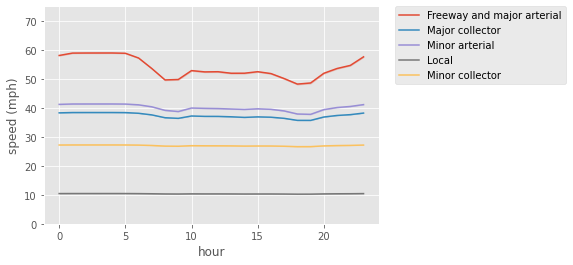

In [13]:
sns.lineplot(x = 'hour', y = 'speed (mph)', hue = 'road_class',
             data = model_vmt_24_hour, ci = 98)
plt.ylim([0, 75])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('plot/' + scenario_name + '/modeled_speed_by_roadtype.png', dpi = 200, bbox_inches= 'tight')
plt.show()

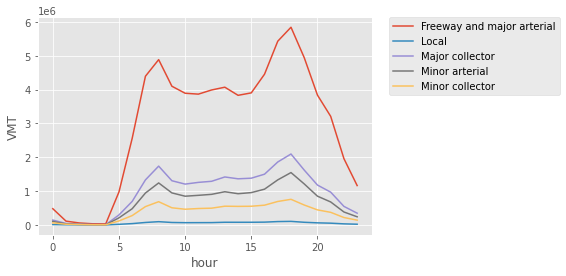

In [14]:
model_vmt_by_hour_roadtype = model_vmt_24_hour.groupby(['hour', 'road_class'])[['VMT']].sum()
model_vmt_by_hour_roadtype = model_vmt_by_hour_roadtype.reset_index()
sns.lineplot(x = 'hour', y = 'VMT', hue = 'road_class',
             data = model_vmt_by_hour_roadtype, ci = None)
# plt.ylim([0, 75])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('plot/' + scenario_name + '/modeled_VMT_by_hour_roadtype.png', dpi = 200, bbox_inches= 'tight')
plt.show()

Santa Clara


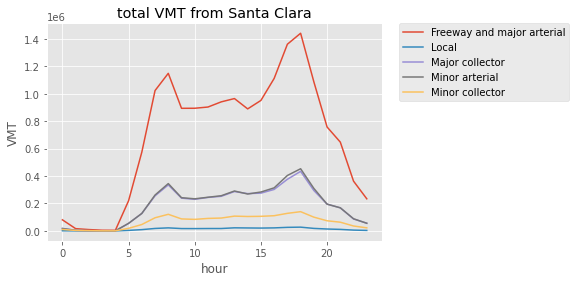

Alameda


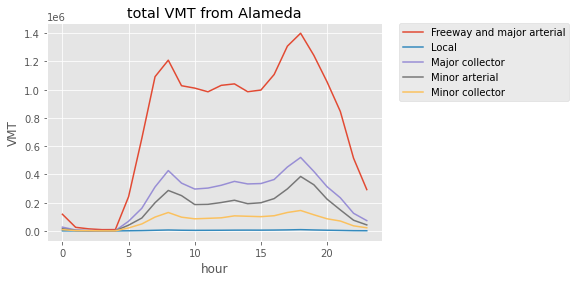

San Mateo


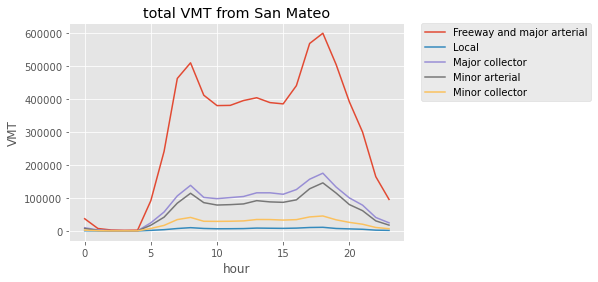

San Francisco


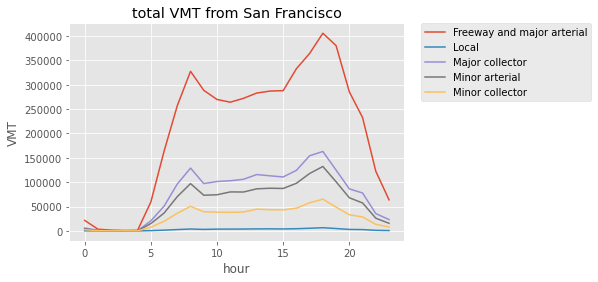

Contra Costa


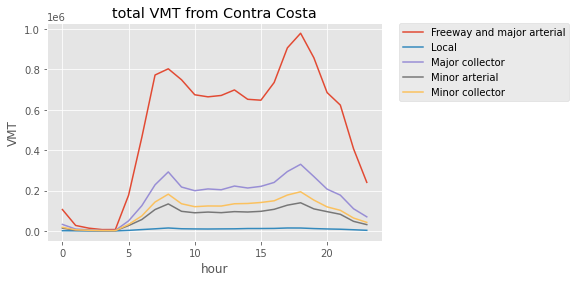

Sonoma


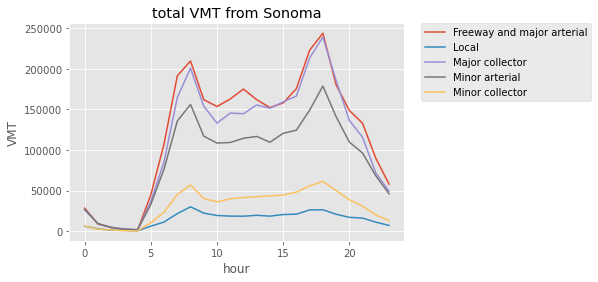

Solano


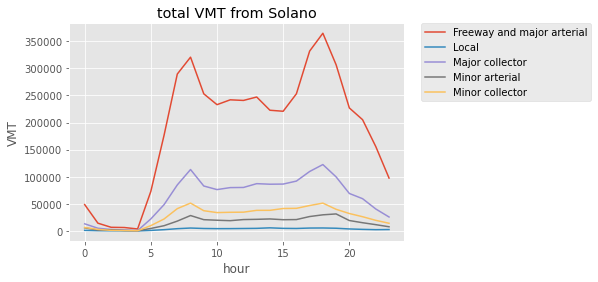

nan


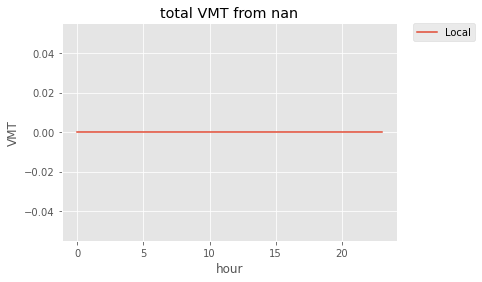

Marin


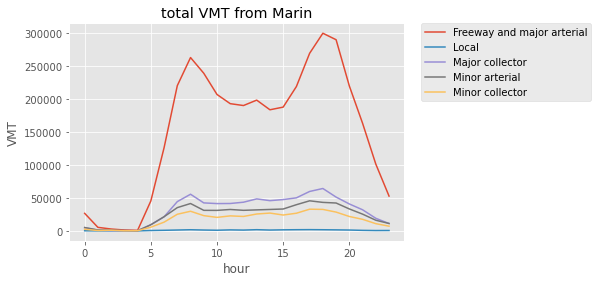

Napa


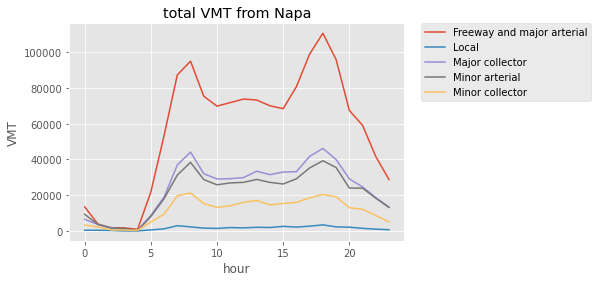

Yolo


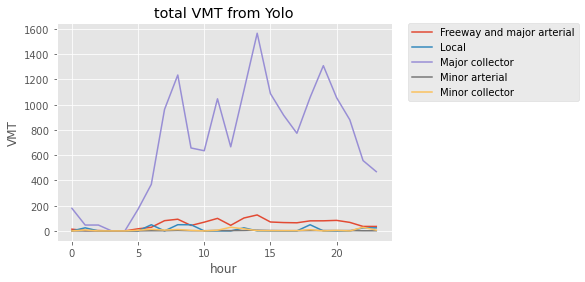

Santa Cruz


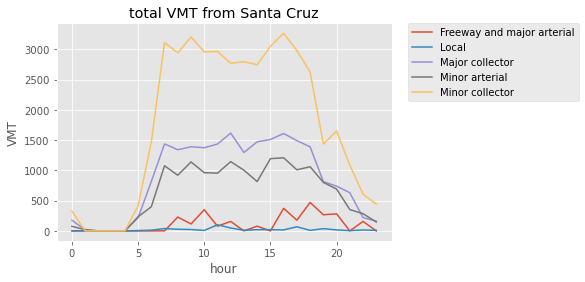

In [15]:
model_vmt_24_hour['NAME'] = model_vmt_24_hour['NAME'].astype(str)
model_vmt_24_hour = model_vmt_24_hour.loc[model_vmt_24_hour['NAME'] != '']
list_of_counties = model_vmt_24_hour.NAME.unique()
for county in list_of_counties:
    print(county)
#     if county == '':
#         continue
    model_vmt_by_county = model_vmt_24_hour.loc[model_vmt_24_hour['NAME'] == county]
    model_vmt_by_hour_county = model_vmt_by_county.groupby(['hour', 'road_class'])[['VMT']].sum()
    model_vmt_by_hour_county = model_vmt_by_hour_county.reset_index()
    sns.lineplot(x = 'hour', y = 'VMT', hue = 'road_class',
                 data = model_vmt_by_hour_county, ci = None)
    # plt.ylim([0, 75])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('total VMT from ' + county)
    plt.savefig('plot/' + scenario_name + '/modeled_VMT_by_hour_' + county + '.png', dpi = 200, bbox_inches= 'tight')
    plt.show()

In [16]:
model_vmt_24_hour_nolocal = model_vmt_24_hour.loc[model_vmt_24_hour['road_class'] != 'Local']
model_vmt_by_county = model_vmt_24_hour_nolocal.groupby(['NAME'])[['VMT']].sum()
model_vmt_by_county = model_vmt_by_county.reset_index()
model_vmt_by_county

observed_vmt_by_county = observed_vmt.groupby('NAME')[['PVMT']].sum()
observed_vmt_by_county = observed_vmt_by_county.reset_index()
observed_vmt_by_county

,NAME,PVMT
0,Alameda,3.608136e+07
1,Contra Costa,2.217956e+07
2,Marin,7.095188e+06
3,Napa,2.589508e+06
4,San Francisco,7.958235e+06
5,San Mateo,1.703756e+07
6,Santa Clara,3.669650e+07
7,Santa Cruz,4.356828e+06
8,Solano,1.188175e+07
9,Sonoma,1.036721e+07


modeled_VMT     1.215227e+08
observed_VMT    1.518869e+08
dtype: float64


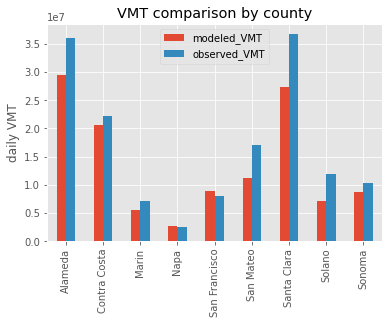

In [17]:
VMT_comparison = pd.merge(model_vmt_by_county, observed_vmt_by_county, 
                          on = 'NAME', how = 'left')
VMT_comparison = VMT_comparison.loc[:, ['NAME', 'VMT', 'PVMT']]
VMT_comparison.columns = ['county', 'modeled_VMT', 'observed_VMT']
VMT_comparison = VMT_comparison.loc[~VMT_comparison['county'].isin(['Santa Cruz', 'Yolo'])] 
print(VMT_comparison.loc[:, ['modeled_VMT', 'observed_VMT']].sum())

VMT_comparison.plot.bar(x = 'county')
plt.xlabel('')
plt.ylabel('daily VMT')
plt.title('VMT comparison by county')
plt.savefig('plot/' + scenario_name + '/VMT_comparison_by_county.png', dpi = 200, bbox_inches = 'tight')
plt.show()

In [18]:
model_vmt_by_roadtype = model_vmt_24_hour.groupby(['road_class'])[['VMT']].sum()
model_vmt_by_roadtype = model_vmt_by_roadtype.reset_index()
observed_vmt_by_roadtype = observed_vmt.groupby(['road_class'])[['PVMT']].sum()
observed_vmt_by_roadtype = observed_vmt_by_roadtype.reset_index()
VMT_comparison_by_roadtype = pd.merge(model_vmt_by_roadtype, observed_vmt_by_roadtype, 
                          on = 'road_class', how = 'left')
# VMT_comparison = VMT_comparison.loc[:, ['name', 'VMT', 'PVMT']]
VMT_comparison_by_roadtype.columns = ['road_class', 'modeled_VMT', 'observed_VMT']
VMT_comparison_by_roadtype

,road_class,modeled_VMT,observed_VMT
0,Freeway and major arterial,7.204399e+07,1.156645e+08
1,Local,1.306720e+06,NaN
2,Major collector,2.364758e+07,1.584947e+07
3,Minor arterial,1.678499e+07,2.619700e+07
4,Minor collector,9.146693e+06,2.687914e+04


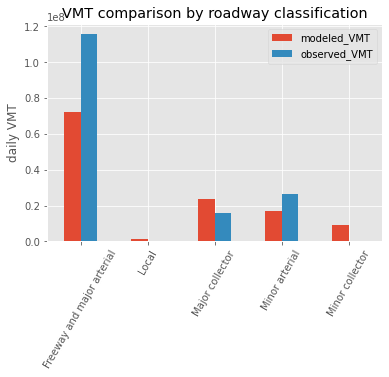

In [19]:
VMT_comparison_by_roadtype.plot.bar(x = 'road_class')
plt.xlabel('')
plt.ylabel('daily VMT')
plt.title('VMT comparison by roadway classification')
plt.xticks(rotation = 60)
plt.savefig('plot/' + scenario_name + '/VMT_comparison_by_roadway_type.png', dpi = 200, bbox_inches = 'tight')
plt.show()

/var/folders/w6/7qcyt43n21ddydhdfdslrp7c0000gp/T/ipykernel_33051/2897943063.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.0f}%'.format(x*100) for x in ax.get_yticks()])


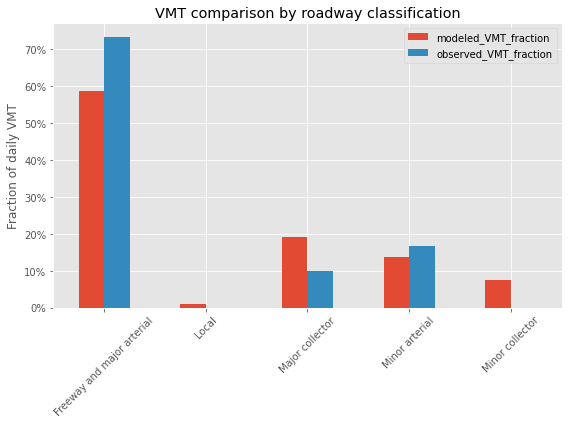

In [20]:
VMT_comparison_by_roadtype.loc[:, 'modeled_VMT_fraction'] = VMT_comparison_by_roadtype.loc[:, 'modeled_VMT'] / VMT_comparison_by_roadtype.loc[:, 'modeled_VMT'].sum()
VMT_comparison_by_roadtype.loc[:, 'observed_VMT_fraction'] = VMT_comparison_by_roadtype.loc[:, 'observed_VMT'] / VMT_comparison_by_roadtype.loc[:, 'observed_VMT'].sum()
percent_VMT_comparison_by_roadtype = VMT_comparison_by_roadtype.loc[:, ['road_class', 'modeled_VMT_fraction', 'observed_VMT_fraction']]

import matplotlib.ticker as mtick
# plt.figure(figsize = (12,8))
ax = percent_VMT_comparison_by_roadtype.plot.bar(x = 'road_class',figsize = (8,6))
# ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
plt.xlabel('')
plt.xticks(rotation = 45)
ax.set_yticklabels(['{:.0f}%'.format(x*100) for x in ax.get_yticks()]) 
# vals = ax.get_yticks()
# ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.ylabel('Fraction of daily VMT')
plt.title('VMT comparison by roadway classification')
plt.tight_layout()
plt.savefig('plot/' + scenario_name + '/percent_VMT_comparison_by_roadway_type.png', dpi = 200)
plt.show()

<AxesSubplot:xlabel='attributeOrigType'>

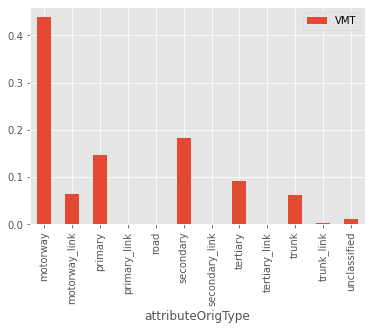

In [19]:
model_vmt_by_osmtype = model_vmt_24_hour.groupby(['attributeOrigType'])[['VMT']].sum()
model_vmt_by_osmtype.loc[:, 'VMT'] /= model_vmt_by_osmtype.loc[:, 'VMT'].sum()
model_vmt_by_osmtype.plot.bar()